In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from music21 import chord, note, stream, clef, meter
from data_cleaning import Open
import os
import numpy as np
import re

In [ ]:
# Vocab

In [5]:
all_chords = []


def open_midi_files(dest_directory):
    for root, dirs, files in os.walk(dest_directory):
        # print(dirs)
        for f_i, file in enumerate(files):
            mid_file = os.path.join(root, file)
            midi_data = Open.open_midi(mid_file)
            all_chords.append(f"<song_{f_i}>")
            # prog_array = []
            el_array = []
            for i, part in enumerate(midi_data.parts):
                all_chords.append(f"<part_{i}>")
                for element in part.recurse():
                    # if isinstance(element, meter.TimeSignature):
                    #     all_chords.append(element.ratioString)
                    if isinstance(element, chord.Chord):
                        all_chords.append("<meta>")
                        all_chords.append(
                            f"chord_quarterlength {element.duration.quarterLength.real}")
                        all_chords.append(f"chord_offset {element.offset}")
                        all_chords.append("<chord_start>")
                        for n in element:
                            all_chords.append(f"note_pitch {n.pitch.midi}")
                            all_chords.append(
                                f"note_velocity {n.volume.velocity}")
                            all_chords.append(
                                f"note_quarterlength {n.duration.quarterLength}")
                            all_chords.append(f"note_offset {n.offset}")
                        all_chords.append("<end>")
                    # elif isinstance(element, chord.Chord):
                    #     # el_array.append([p.midi for p in element.pitches])
                    #     pass
                # if el_array:
                #     prog_array.append(el_array)

            # all_chords.append(el_array)


open_midi_files(os.path.join(os.getcwd(), "sample_rock_set"))

In [17]:
chars = sorted(list(set(all_chords)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}

# for i in chars:
#     match = re.search(r'(?<=\s)(.*)', i)
#     # print(match)

#     if match:
#         number = match.group()
#         print(eval(number))
#     else:
#         print(i)

itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers

# def decode(l):
#     for piece in l:
#         print(piece)
decode = lambda l: '\n'.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(all_chords), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [18]:
block_size = 8

x = decode(train_data[:block_size+1].tolist())

In [19]:
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([14]) the target: 3
when input is tensor([14,  3]) the target: 2
when input is tensor([14,  3,  2]) the target: 56
when input is tensor([14,  3,  2, 56]) the target: 28
when input is tensor([14,  3,  2, 56, 28]) the target: 0
when input is tensor([14,  3,  2, 56, 28,  0]) the target: 130
when input is tensor([ 14,   3,   2,  56,  28,   0, 130]) the target: 247
when input is tensor([ 14,   3,   2,  56,  28,   0, 130, 247]) the target: 160


In [21]:
torch.manual_seed(1337)
batch_size = 4  # how many independent sequences will we process in parallel?
block_size = 8  # what is the maximum context length for predictions?


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size):  # batch dimension
    for t in range(block_size):  # time dimension
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 56,  39,   0, 124, 247, 160,  92, 119],
        [199, 160,  92, 120, 199, 160,  92,   1],
        [160,  92,   1,   2,  85,  48,   0, 130],
        [122, 247, 160,  92, 110, 247, 160,  92]])
targets:
torch.Size([4, 8])
tensor([[ 39,   0, 124, 247, 160,  92, 119, 247],
        [160,  92, 120, 199, 160,  92,   1,   2],
        [ 92,   1,   2,  85,  48,   0, 130, 184],
        [247, 160,  92, 110, 247, 160,  92,   1]])
----
when input is [56] the target: 39
when input is [56, 39] the target: 0
when input is [56, 39, 0] the target: 124
when input is [56, 39, 0, 124] the target: 247
when input is [56, 39, 0, 124, 247] the target: 160
when input is [56, 39, 0, 124, 247, 160] the target: 92
when input is [56, 39, 0, 124, 247, 160, 92] the target: 119
when input is [56, 39, 0, 124, 247, 160, 92, 119] the target: 247
when input is [199] the target: 160
when input is [199, 160] the target: 92
when input is [199, 160, 92] the target: 120
when input is [199, 16

In [22]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx)  # (B,T,C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


m = BigramLanguageModel(vocab_size)
# print(m.token_embedding_table)
# print(xb)
logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)

# print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=10)[0].tolist()))

In [23]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [24]:
losses = []

In [ ]:
batch_size = 128
for steps in range(10000):
    xb, yb = get_batch('train')

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 100 == 0:
        losses.append(loss.item())
        print(loss.item())

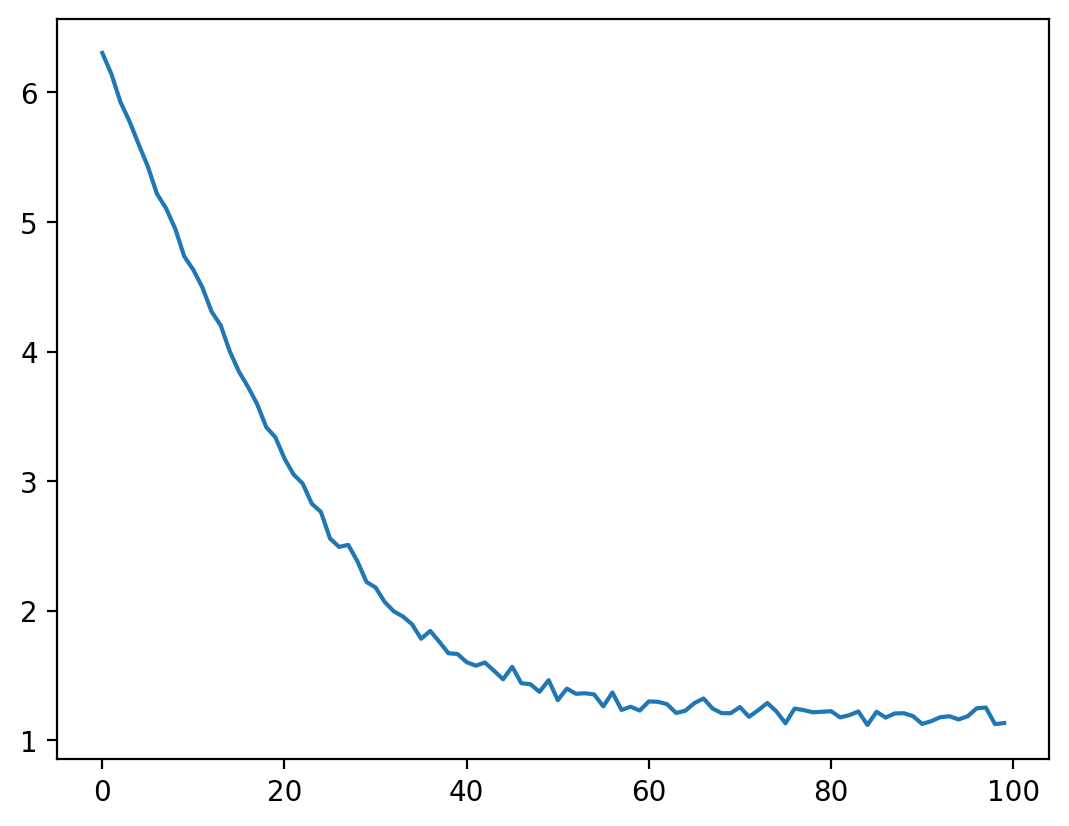

In [26]:
plt.plot(losses)

In [27]:
print(decode(m.generate(idx=torch.zeros(
    (1, 1), dtype=torch.long), max_new_tokens=20)[0].tolist()))

<chord_start>
note_pitch 61
note_velocity 80
note_quarterlength 1.0
note_offset 0.0
<end>
<meta>
chord_quarterlength 0.25
chord_offset 2.75
<chord_start>
note_pitch 61
note_velocity 80
note_quarterlength 1.0
note_offset 0.0
<end>
<meta>
chord_quarterlength 0.25
chord_offset 2.5
<chord_start>
note_pitch 60
note_velocity 95
